# Preprocessing of the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import datetime
import sklearn

#from google.colab import drive
#drive.mount('/content/drive')

Import the data for the NJ train network. Month of March 2018. Drop the observations with NaN delay.

In [2]:
#for colab : df = pd.read_csv('/content/Outward.csv')

df = pd.read_csv('Outward.csv')
df.dropna(subset=['delay_minutes'], inplace=True)
df.reset_index(drop=True, inplace=True)

Encoding the days of the week (0 : Monday ..., 6 : Sunday) 

In [3]:
day = []
time = []

for (k,v) in enumerate(df['actual_time']):
    aux = datetime.datetime.strptime(v, '%Y-%m-%d %H:%M:%S')
    time_only = aux.time()
    day.append(aux.weekday())
    time_in_min = time_only.hour*60 + time_only.minute
    time.append(time_in_min)
    
df['day'] = day
df['time'] = time

In [4]:
df.head(n=5)

,Unnamed: 0,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type,day,time
0,0,2018-03-01,3805,1.0,New York Penn Station,105,New York Penn Station,105,2018-03-02 01:22:00,2018-03-02 01:21:05,0.000000,departed,Northeast Corrdr,NJ Transit,4,81
1,1,2018-03-01,3805,2.0,New York Penn Station,105,Secaucus Upper Lvl,38187,2018-03-02 01:31:00,2018-03-02 01:31:08,0.133333,departed,Northeast Corrdr,NJ Transit,4,91
2,2,2018-03-01,3805,3.0,Secaucus Upper Lvl,38187,Newark Penn Station,107,2018-03-02 01:40:00,2018-03-02 01:40:07,0.116667,departed,Northeast Corrdr,NJ Transit,4,100
3,3,2018-03-01,3805,4.0,Newark Penn Station,107,Newark Airport,37953,2018-03-02 01:45:00,2018-03-02 01:45:10,0.166667,departed,Northeast Corrdr,NJ Transit,4,105
4,4,2018-03-01,3805,5.0,Newark Airport,37953,North Elizabeth,109,2018-03-02 01:49:00,2018-03-02 01:49:10,0.166667,departed,Northeast Corrdr,NJ Transit,4,109


Encoding the line names and the departure station with label encoding

In [5]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

df['line'] = le.fit_transform(df['line'])
df['from_id'] = le.fit_transform(df['from_id'])
df['train_id'] = le.fit_transform(df['train_id'])

In [6]:
df.head(5)

,Unnamed: 0,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type,day,time
0,0,2018-03-01,262,1.0,New York Penn Station,85,New York Penn Station,105,2018-03-02 01:22:00,2018-03-02 01:21:05,0.000000,departed,6,NJ Transit,4,81
1,1,2018-03-01,262,2.0,New York Penn Station,85,Secaucus Upper Lvl,38187,2018-03-02 01:31:00,2018-03-02 01:31:08,0.133333,departed,6,NJ Transit,4,91
2,2,2018-03-01,262,3.0,Secaucus Upper Lvl,143,Newark Penn Station,107,2018-03-02 01:40:00,2018-03-02 01:40:07,0.116667,departed,6,NJ Transit,4,100
3,3,2018-03-01,262,4.0,Newark Penn Station,87,Newark Airport,37953,2018-03-02 01:45:00,2018-03-02 01:45:10,0.166667,departed,6,NJ Transit,4,105
4,4,2018-03-01,262,5.0,Newark Airport,139,North Elizabeth,109,2018-03-02 01:49:00,2018-03-02 01:49:10,0.166667,departed,6,NJ Transit,4,109


In [7]:
df.drop(columns = ['date','from','to','to_id','scheduled_time','status','type','actual_time'], inplace = True)

In [8]:
df.head(n=5)
df['delay_seconds'] = df['delay_minutes']*60
df.drop(columns=['delay_minutes'],inplace=True)
#len(df)


In [9]:
df.sort_values(by=['train_id','day'])
df.head(50)
len(df[df['line']==6])

19403

In [10]:
df.head(5)

,Unnamed: 0,train_id,stop_sequence,from_id,line,day,time,delay_seconds
0,0,262,1.0,85,6,4,81,0.0
1,1,262,2.0,85,6,4,91,8.0
2,2,262,3.0,143,6,4,100,7.0
3,3,262,4.0,87,6,4,105,10.0
4,4,262,5.0,139,6,4,109,10.0


Trial on one line, for one stop

In [11]:
#The create_dataset function is greatly inspired by : 
#https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

# LSTM with window regression framing

import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#for colab : 
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :] #it can take as many features as we want 
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

Using TensorFlow backend.


In [12]:
# fix random seed for reproducibility
numpy.random.seed(7)

# load the dataset, I chose to work on line 6 only as an example
df_line_6 = df[df['line']==6]
dataset = df_line_6[['delay_seconds','time']] #adding delays and actual time as a feature

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

dataset_test = dataset[df_line_6['stop_sequence'] == 10]
dataset_train = dataset[df_line_6['stop_sequence'] != 10]

#dataset_test = dataset_test.values
dataset_test = dataset_test.astype('float32')

#dataset_train = dataset_train.values
dataset_train = dataset_train.astype('float32')


In [13]:
#Sanity check

print(dataset.shape)
print(dataset_train.shape)
print(dataset_test.shape)

(19403, 2)
(18270, 2)
(1133, 2)


In [14]:
# split into train and test sets
train = dataset_train
test = dataset_test

# reshape into X=t and Y=t+look_back-1
look_back = 4 #for example
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input dimensions to be [delay, time, features] with the features being the previous delays and time
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))

In [15]:
#Sanity check

print(testX.shape)
print(testY.shape)

(1128, 4, 2)
(1128,)


In [16]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(10, input_shape=(look_back, 2)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)
model.summary()

Epoch 1/10
 - 35s - loss: 0.0032
Epoch 2/10
 - 36s - loss: 0.0027
Epoch 3/10
 - 38s - loss: 0.0027
Epoch 4/10
 - 43s - loss: 0.0027
Epoch 5/10
 - 42s - loss: 0.0027
Epoch 6/10
 - 39s - loss: 0.0027
Epoch 7/10
 - 37s - loss: 0.0026
Epoch 8/10
 - 37s - loss: 0.0027
Epoch 9/10
 - 37s - loss: 0.0026
Epoch 10/10
 - 38s - loss: 0.0026
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10)                520       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 531
Trainable params: 531
Non-trainable params: 0
_________________________________________________________________


In [17]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [18]:
#for now, manual inverse scaling, so we should get the min and max for each set

df_stop_test = df_line_6[df_line_6['stop_sequence']==10]
df_groundtruth_test = df_stop_test['delay_seconds']

df_stop_train = df_line_6[df_line_6['stop_sequence']!=10]
df_groundtruth_train = df_stop_train['delay_seconds']


In [19]:
print(np.max(df_groundtruth_test))
print(np.max(df_groundtruth_train))

5100.0
5305.000000002


In [20]:
#Inverse scaling

trainPredict_norm = trainPredict*5305
testPredict_norm = testPredict*5305
trainY_norm = trainY*5305
testY_norm = testY*5305

In [21]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY_norm, trainPredict_norm[:,0]))
print('Train Score in minutes: %.2f RMSE' % (trainScore/60))
testScore = math.sqrt(mean_squared_error(testY_norm, testPredict_norm[:,0]))
print('Test Score in minutes: %.2f RMSE' % (testScore/60))

Train Score in minutes: 4.50 RMSE
Test Score in minutes: 10.13 RMSE


In [22]:
#Transform back to delays in minutes, the time still has to change too

groundtruth_test = df_groundtruth_test.to_numpy()
groundtruth_train = df_groundtruth_train.to_numpy()

df_time = df['time'][(df['line'] == 6) & (df['stop_sequence']==10)]/60
np.max(df_time)

df_test_plot = pd.DataFrame()
df_test_plot['Time [hour]'] = df_time[4:-1] 
df_test_plot['TestY [min]'] = testY_norm*5305/5100/60
df_test_plot['Predict [min]'] = testPredict_norm/60
df_test_plot['Groundtruth [min]'] = groundtruth_test[4:-1]/60 #attention to this, caused by the look back

df_test_plot.head() #sanity check

,Time [hour],TestY [min],Predict [min],Groundtruth [min]
511,16.633333,1.092206,47.163326,1.050000
582,17.366667,1.248235,3.472070,1.200000
945,10.483333,36.701588,1.963092,35.283333
1018,9.016667,1.300245,29.474165,1.250000
1331,22.816667,2.236421,3.013185,2.150000


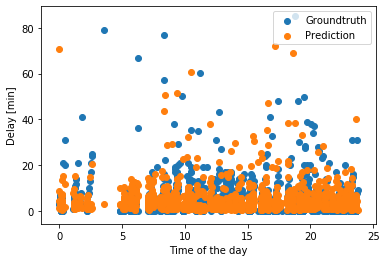

In [33]:
ax1 = plt.scatter(df_test_plot['Time [hour]'],df_test_plot['Groundtruth [min]'],label='Groundtruth')
ax2 = plt.scatter(df_test_plot['Time [hour]'],df_test_plot['Predict [min]'],label='Prediction')
#plt.title('Prediction of delays at stop "Metropark", on line "Northeast Corridor" for outward trips ')
plt.ylabel('Delay [min]')
plt.xlabel('Time of the day')
plt.legend()
plt.savefig('./Images and Gifs/LSTM_plot.pdf')

plt.show()
